# Airfoil Noise Prediction

## Dataset used: 
UCI Airfoil Self-Noise Data Set

https://archive.ics.uci.edu/ml/datasets/airfoil+self-noise#

The airfoil self-noise dataset has:
- 5 features (first 5 columns in the dataset):
    - Frequency [Hz]
    - Angle of attack [degrees]
    - Chord length [m]
    - Free-stream velocity [m/s]
    - Suction side displacement thickness [m]
- Output (last column in the dataset):
    - Sound Pressure Level [dB] 

## Flow Conditions That Produce Airfoil Self-Noise
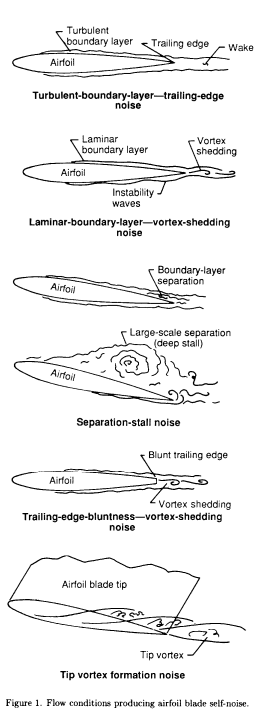

## References
[1] Thomas F. Brooks, D. Stuart Pope, and Michael A. Marcolini. Airfoil self-noise and prediction. NTRS Author
Affiliations: PRC Kentron, Inc., Hampton, NASA Langley Research Center NTRS Report/Patent Number: L-
16528 NTRS Document ID: 19890016302 NTRS Research Center: Legacy CDMS (CDMS). July 1989. url: https://ntrs.nasa.gov/citations/19890016302.

[2] Roberto Lopez. Airfoil Self-Noise Data Set. Mar. 2014. url: https://archive.ics.uci.edu/ml/datasets/airfoil+self-noise.

[3] Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

## Import Modules

In [1]:
# libraries
import os
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# PyTorch
import torch

# For PyTorch Dataset & Dataloader
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.io import read_image
from torchvision.transforms import ToTensor

# For PyTorch Neural Network
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary

c:\Users\whdqk\anaconda3\envs\sam\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Check CUDA Availability

In [2]:
# check your PyTorch version
print(torch.__version__)

1.13.0


In [3]:
# check if GPU is available in your device
cuda_available = torch.cuda.is_available()
print(cuda_available)

True


In [4]:
# Set Device: check pytorch cuda and use cuda if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('*' * 50)
if torch.cuda.is_available():  
    print('CUDA is found: %s.' %torch.cuda.get_device_name(0))
else:
    print('CUDA not found! Training may be slow......')

**************************************************
CUDA is found: NVIDIA GeForce GTX 1650 with Max-Q Design.


## Airfoil Self-Noise Dataset

In [5]:
# dataset
dataset = np.loadtxt('airfoil_self_noise.dat')
dataset_df = pd.DataFrame(dataset)
dataset_df.columns = ["Frequency [Hz]", "Angle of attack [deg]", "Chord length [m]", "Free-stream velocity [m/s]", "Suction side displacement thickness [m]", "Scaled sound pressure level [dB]"]
dataset_df.head() # display first 5 rows

,Frequency [Hz],Angle of attack [deg],Chord length [m],Free-stream velocity [m/s],Suction side displacement thickness [m],Scaled sound pressure level [dB]
0,800.0,0.0,0.3048,71.3,0.002663,126.201
1,1000.0,0.0,0.3048,71.3,0.002663,125.201
2,1250.0,0.0,0.3048,71.3,0.002663,125.951
3,1600.0,0.0,0.3048,71.3,0.002663,127.591
4,2000.0,0.0,0.3048,71.3,0.002663,127.461


## Feature Engineering

### Shuffle the Dataset

In [6]:
dataset_norm_shuffled = copy.deepcopy(dataset)
np.random.seed(0)
np.random.shuffle(dataset_norm_shuffled) # shuffle
dataset_norm_shuffled_df = pd.DataFrame(dataset_norm_shuffled)
dataset_norm_shuffled_df.columns = ["Frequency [Hz]", "Angle of attack [deg]", "Chord length [m]", "Free-stream velocity [m/s]", "Suction side displacement thickness [m]", "Scaled sound pressure level [dB]"]
dataset_norm_shuffled_df

,Frequency [Hz],Angle of attack [deg],Chord length [m],Free-stream velocity [m/s],Suction side displacement thickness [m],Scaled sound pressure level [dB]
0,10000.0,0.0,0.0254,71.3,0.000401,130.787
1,6300.0,0.0,0.3048,71.3,0.002663,119.541
2,2500.0,12.3,0.1016,31.7,0.041876,110.317
3,400.0,17.4,0.0254,71.3,0.016104,117.396
4,2500.0,15.4,0.0508,71.3,0.026427,127.625
...,...,...,...,...,...,...
1498,12500.0,0.0,0.0508,39.6,0.000792,123.988
1499,1250.0,8.4,0.0508,31.7,0.005808,130.156
1500,1250.0,22.2,0.0254,71.3,0.021418,140.987
1501,1250.0,5.4,0.1524,55.5,0.004333,130.777


### 80 10 10 Train Test Validation Split
Let's split the dataset into 80% training, 10% testing, and 10% validation before performing normalization to avoid data leakage.

In [7]:
dataset.shape # shape of dataset

(1503, 6)

In [8]:
train_data, test_data = train_test_split(dataset, test_size=0.1, random_state=1)
train_data, valid_data = train_test_split(train_data, test_size=0.11, random_state=1)

### Normalize the Dataset

In [9]:
# features
train_data_features = train_data[:, :-1]
test_data_features = test_data[:, :-1]
valid_data_features = valid_data[:, :-1]

# output
train_data_labels = train_data[:, -1]
test_data_labels = test_data[:, -1]
valid_data_labels = valid_data[:, -1]

In [10]:
# normalize the features
scaler = StandardScaler().fit(train_data_features)
train_data_features = scaler.transform(train_data_features)
test_data_features = scaler.transform(test_data_features)
valid_data_features = scaler.transform(valid_data_features)
print()

In [11]:
train_data = np.concatenate((train_data_features, train_data_labels.reshape(-1, 1)), axis=1)
test_data = np.concatenate((test_data_features, test_data_labels.reshape(-1, 1)), axis=1)
valid_data = np.concatenate((valid_data_features, valid_data_labels.reshape(-1, 1)), axis=1)

### Normalized Train Data (features are normalized; output is not normalized)

In [12]:
train_data_norm_df = pd.DataFrame(train_data)
train_data_norm_df.columns = ["Frequency", "Angle of attack", "Chord length", "Free-stream velocity", "Suction side displacement thickness", "Scaled sound pressure level [dB]"]
train_data_norm_df

,Frequency,Angle of attack,Chord length,Free-stream velocity,Suction side displacement thickness,Scaled sound pressure level [dB]
0,-0.803500,2.610182,-1.194056,1.310745,0.766018,115.857
1,-0.777520,0.093427,0.983620,0.292665,-0.000050,135.924
2,-0.594133,0.532592,0.166991,-0.731860,0.909181,123.835
3,-0.517721,0.279228,-0.921846,-1.240900,-0.400969,130.156
4,-0.594133,-0.463975,0.983620,1.310745,-0.535664,131.708
...,...,...,...,...,...,...
1198,-0.707222,-0.463975,0.983620,0.292665,-0.514719,129.964
1199,0.628450,1.799415,-1.194056,-1.240900,0.485321,117.996
1200,-0.288487,1.461596,-0.921846,1.310745,1.140492,129.285
1201,-0.655262,-1.139614,1.800248,-0.731860,-0.603294,129.099


### Normalized Test Data (features are normalized; output is not normalized)

In [13]:
test_data_norm_df = pd.DataFrame(test_data)
test_data_norm_df.columns = ["Frequency", "Angle of attack", "Chord length", "Free-stream velocity", "Suction side displacement thickness", "Scaled sound pressure level [db]"]
test_data_norm_df

,Frequency,Angle of attack,Chord length,Free-stream velocity,Suction side displacement thickness,Scaled sound pressure level [db]
0,0.322804,-0.886250,1.800248,-0.731860,-0.542015,117.741
1,1.025790,-0.886250,1.800248,1.310745,-0.583415,118.122
2,-0.707222,2.610182,-1.194056,1.310745,0.766018,120.657
3,-0.803500,-0.463975,0.983620,-0.731860,-0.480942,122.229
4,-0.746956,-0.007919,-0.377428,0.292665,-0.445365,129.343
...,...,...,...,...,...,...
146,-0.803500,1.495378,-0.377428,1.310745,2.433743,133.808
147,-0.288487,-0.632885,1.800248,1.310745,-0.516881,125.524
148,-0.777520,1.799415,-1.194056,0.292665,0.403648,115.461
149,1.025790,-0.801795,0.983620,1.310745,-0.616083,120.786


### Normalized Validation Data (features are normalized; output is not normalized)

In [14]:
valid_data_norm_df = pd.DataFrame(valid_data)
valid_data_norm_df.columns = ["Frequency", "Angle of attack", "Chord length", "Free-stream velocity", "Suction side displacement thickness", "Scaled sound pressure level [dB]"]
valid_data_norm_df

,Frequency,Angle of attack,Chord length,Free-stream velocity,Suction side displacement thickness,Scaled sound pressure level [dB]
0,-0.410745,0.532592,0.166991,-1.240900,1.054639,117.119
1,-0.823367,0.532592,0.166991,0.292665,0.723107,133.235
2,0.628450,-1.139614,-0.377428,-1.240900,-0.722943,124.393
3,-0.707222,-0.463975,1.800248,1.310745,-0.463021,131.615
4,-0.777520,-0.244393,0.983620,-0.731860,-0.375885,131.221
...,...,...,...,...,...,...
144,0.063005,0.752175,-0.921846,1.310745,0.216855,127.141
145,-0.746956,1.005540,-1.194056,1.310745,0.075472,126.898
146,1.545387,-1.139614,1.800248,-1.240900,-0.587499,110.515
147,-0.410745,0.532592,0.166991,1.310745,0.607702,121.789


## Data Handling

### Custom Dataset

In [15]:
class CustomDataset(Dataset):
    def __init__(self, data, transform=None, target_transform=None):
        self.data = data
    
    def __len__(self):
        return len(self.data[:,0])
    
    def __getitem__(self, idx):
        features = self.data[:,0:-1][idx] # features values
        labels = self.data[:,-1][idx] # label (output): Sound Pressure Level
        return features, labels


## Neural Network Model Architecture

### Multi-Layer Perceptron

In [16]:
# Create a MLP
class MLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_nodes=32, activation=nn.ReLU()): # __init__: let variables be global by having them as attributes of 'self'
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_nodes), # first hidden layer 1(input size, output size)
            activation,
            nn.Linear(hidden_nodes, hidden_nodes*4), # (input size, output size)
            activation,
            nn.Linear(hidden_nodes*4, hidden_nodes*16), # (input size, output size)
            activation,
            nn.Linear(hidden_nodes*16, hidden_nodes*4), # (input size, output size)
            activation,
            nn.Linear(hidden_nodes*4, hidden_nodes), # (input size, output size)
            activation,
            nn.Linear(hidden_nodes, output_size) # output layer (input size, output size)
            )

    def forward(self, input): # forward pass
        # input = input.to(torch.float32) # keep the input's dtype as float32
        input = input.float()
        return self.layers(input)

## Train

In [17]:
# Training
def train(model, train_dataset, valid_dataset, hyperparameters):

    # Hyperparameters
    epochs = hyperparameters["epochs"] # how many times you want to train
    lr = hyperparameters["lr"] # learning rate
    batch_size = hyperparameters["batch_size"] # how many data points you want to train at once
    weight_decay = hyperparameters["weight_decay"] # regularizer
    criterion = hyperparameters["criterion"] # loss function for regression task

    # Dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

    # optimizer
    optimizer = optim.Adam(model.parameters(), lr) # optimizer = backprop + optimization; Optimze the parameters

    # initial variables
    train_loss_epoch = []; valid_loss_epoch = []

    # TRAINING
    for epoch in tqdm(range(epochs)):

        train_loss = 0; valid_loss =0 # reset at every epoch
        train_count = 0; valid_count = 0

        # TRAINING BY FITTING THE MODEL TO THE TRAINING DATA
        for batch, (features, labels) in enumerate(train_loader):
            features = features.to(device=device)
            labels = labels.unsqueeze(1).to(device=device) # unsqueeze(1) to add 1 more dimension
            # SET GRADIENTS TO 0 FOR EACH BATCH
            optimizer.zero_grad()
            # FORWARD PASS & PREDICTION
            pred = model(features)
            # COMPUTE LOSS
            loss = criterion(pred.float(), labels.float())
            # BACKPROPAGATION
            loss.backward()
            # UPDATE WEIGHTS
            optimizer.step()
            # LOSS SUM
            train_loss += loss.item()
            # COUNT ACTUAL BATCH SIZE
            train_count += 1

        # TRAINING BY FITTING THE MODEL TO THE VALIDATION DATA
        for batch, (features, labels) in enumerate(valid_loader):
            features = features.to(device=device)
            labels = labels.unsqueeze(1).to(device=device) # unsqueeze(1) to add 1 more dimension
            # FORWARD PASS & PREDICTION
            pred = model(features)
            # COMPUTE LOSS
            loss = criterion(pred.float(), labels.float())
            # LOSS SUM
            valid_loss += loss.item()
            # COUNT ACTUAL BATCH SIZE
            valid_count += 1
        
        # Loss over epochs
        train_loss_epoch.append(train_loss/train_count) # batch mean train loss per epoch
        valid_loss_epoch.append(valid_loss/valid_count) # batch mean validation loss per epoch
    
        # Print training progress
        if epoch % 100 == 0:
            print("Batch Mean Train Loss per Epoch: {0:.4f}\nBatch Mean Validation Loss per Epoch: {1:.4f}".format(train_loss/train_count, valid_loss/valid_count))

    # Save the trained model parameters
    torch.save(model.state_dict(), "./p1_model.pt")

    # Save the entire trained model
    torch.save(model, 'p1_whole_model.pt')
    
    return model, train_loss_epoch, valid_loss_epoch

## Train Loss, Validation Loss, Test Error

  0%|          | 1/500 [00:01<16:26,  1.98s/it]

Batch Mean Train Loss per Epoch: 15019.7037
Batch Mean Validation Loss per Epoch: 12661.2066


 20%|██        | 101/500 [00:25<01:35,  4.20it/s]

Batch Mean Train Loss per Epoch: 10.1582
Batch Mean Validation Loss per Epoch: 8.2049


 40%|████      | 201/500 [00:55<02:40,  1.86it/s]

Batch Mean Train Loss per Epoch: 3.8066
Batch Mean Validation Loss per Epoch: 4.0337


 60%|██████    | 301/500 [01:31<01:16,  2.61it/s]

Batch Mean Train Loss per Epoch: 2.7678
Batch Mean Validation Loss per Epoch: 5.1775


 80%|████████  | 401/500 [02:07<00:34,  2.86it/s]

Batch Mean Train Loss per Epoch: 2.2691
Batch Mean Validation Loss per Epoch: 3.9995


100%|██████████| 500/500 [02:41<00:00,  3.09it/s]


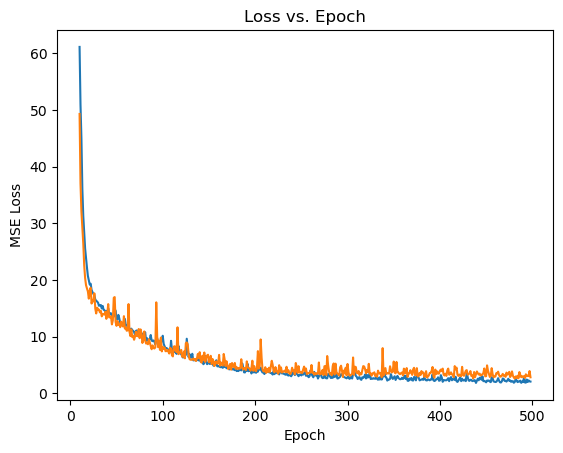

In [18]:
if __name__ == '__main__':
    torch.manual_seed(137)

    # Load in the provided data
    train_data
    valid_data
    test_data

    # Custom dataset
    train_dataset = CustomDataset(train_data)
    valid_dataset = CustomDataset(valid_data)

    # Hyperparameters
    hyperparameters = {
                    "epochs": 500, "batch_size": 2**5, "lr": 0.0005, 
                    "weight_decay": 1e-2, 
                    "criterion": nn.MSELoss(reduction='mean')
                    }
                    
    # input and output size
    num_features = 5 # the number of features
    input_size = num_features # input size = num of features
    num_output = 1 # the number of output
    output_size = num_output # output size = num of output


    # initialize network
    model = MLP(input_size=input_size, output_size=output_size).to(device)

    # trained model
    model_trained, train_losses, val_losses = train(model=model,
                                                    train_dataset=train_dataset, 
                                                    valid_dataset=valid_dataset,
                                                    hyperparameters=hyperparameters
                                                    )

    # Plot
    train_loss = train_losses[10:-1]
    valid_loss = val_losses[10:-1]
    plt.plot(range(10, len(train_loss) + 10), train_loss, label='Train Loss')
    plt.plot(range(10, len(valid_loss) + 10), valid_loss, label='Validation Loss')
    plt.title("Loss vs. Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.show()

### Compute Test Error

In [19]:
# custom dataset
test_dataset = CustomDataset(test_data)
# dataloader
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [20]:
# compute test error for every data
with torch.no_grad(): # gradients won't be computed here
    error_list = []
    for batch, (features, labels) in enumerate(test_loader):
        features = features.to(device=device)
        labels = labels.unsqueeze(1).to(device=device) # unsqueeze(1) to add 1 more dimension
        prediction = model(features)
        error = nn.MSELoss()(prediction, labels).item()
        error_list.append(error)
    test_error = np.sum(error_list)


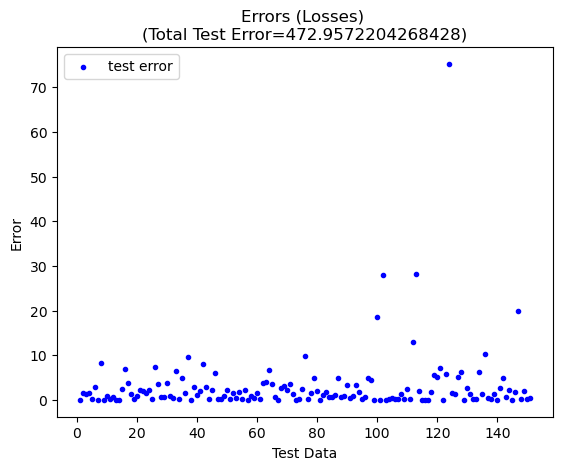

In [50]:
# plot test error
len_test = len(test_data[:,0])
plt.scatter(np.linspace(1,len_test,len_test), error_list, marker='.', c='b', 
    label=f'test error')
plt.title(f"Errors (Losses) \n(Total Test Error={test_error})")
plt.xlabel("Test Data")
plt.ylabel("Error")
plt.legend()
plt.show()

## Evaluate Our Trained Model

In [51]:
def evaluate_model(model, test_data):
    test_dataset = CustomDataset(test_data)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    with torch.no_grad():
        total_loss = 0
        pred_list = []
        for features, label in test_loader:
            x = features.to(device=device) # features
            y = label.to(device=device) # ground truth label (scaled sound pressure level)
            pred = model(x) # prediction from the trained model
            pred_list.append(pred.item())
            total_loss += nn.MSELoss()(pred, y).item() # total test loss (error)
    avg_loss = total_loss / len(test_data) # average test loss
    print(f"Average MSE Test Loss: {avg_loss} [dB]")

    # normalized predictions
    pred_list_df = pd.DataFrame(pred_list)
    pred_list_df.columns = ["Predicted scaled sound pressure level [dB]"]
    predicted_sound_pressureds = pred_list_df

    # normalized ground truths
    test_data_df = pd.DataFrame(test_data)
    ground_truth_sound_pressures = test_data_df.iloc[:,-1:]
    ground_truth_sound_pressures.columns = ["Ground truth scaled sound pressure level [dB]"]

    # compare
    compare_df = pd.concat([ground_truth_sound_pressures, predicted_sound_pressureds], axis=1)

    return compare_df


In [52]:
evaluate_model(model_trained, test_data)

c:\Users\whdqk\anaconda3\envs\sam\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average MSE Test Loss: 3.132167022694323 [dB]


,Ground truth scaled sound pressure level [dB],Predicted scaled sound pressure level [dB]
0,117.741,117.966446
1,118.122,116.911797
2,120.657,121.765678
3,122.229,123.480240
4,129.343,128.877960
...,...,...
146,133.808,129.337830
147,125.524,125.079384
148,115.461,114.081985
149,120.786,120.253433
